In [13]:
# Import Packaging
import pandas as pd
from pandas import read_csv
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
import shap

import xarray as xr
import pandas as pd
import glob
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.utils import resample


In [14]:
# Data Collection & Cleaning

# Read data
monthly_streamflow = pd.read_csv('StreamflowMonthlyData.csv') # discharge in cfs
weather = pd.read_csv('NOAA_weather_data2.csv', sep=';')

# Transform weather data into monthly averages
# First split year column into year and month
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather = weather.set_index('DATE')
monthly_weather = weather.resample('M').agg({
    'PRCP': 'mean',      # monthly average precipitation ( in inches !)
    'TMAX': 'mean',     # monthly average high temp (in Farenheit !)
    'TMIN': 'mean',      # monthly average low temp (in Farenheit !)
    'SNWD': 'mean',      # monthly average snow depth
    'SNOW': 'mean'      # monthly average snowfall
})
monthly_weather['year'] = monthly_weather.index.year
monthly_weather['month'] = monthly_weather.index.month
monthly_weather['PRCP'] = monthly_weather['PRCP'] * 25.4  # convert inches to mm

# Remove 'DATE' column/index
monthly_weather = monthly_weather.reset_index()  
monthly_weather = monthly_weather.drop(columns=['DATE'])

# Reorder columns
monthly_weather = monthly_weather[['year', 'month', 'PRCP', 'TMAX', 'TMIN', 'SNWD', 'SNOW']]

# Merge streamflow and weather data on year and month
merged_data = pd.merge(monthly_streamflow, monthly_weather, on=['year', 'month'])
merged_data = merged_data.drop(columns=['SNWD', 'SNOW'], errors='ignore')

# --- Create 1, 2, 3-month Climate Lags ---

# 1-month
merged_data['PRCP_lag_1'] = merged_data['PRCP'].shift(1)
merged_data['TMIN_lag_1'] = merged_data['TMIN'].shift(1)
merged_data['TMAX_lag_1'] = merged_data['TMAX'].shift(1)

# 2-month
merged_data['PRCP_lag_2'] = merged_data['PRCP'].shift(2)
merged_data['TMIN_lag_2'] = merged_data['TMIN'].shift(2)
merged_data['TMAX_lag_2'] = merged_data['TMAX'].shift(2)

# 3-month
merged_data['PRCP_lag_3'] = merged_data['PRCP'].shift(3)
merged_data['TMIN_lag_3'] = merged_data['TMIN'].shift(3)
merged_data['TMAX_lag_3'] = merged_data['TMAX'].shift(3)

# extended precip
merged_data['PRCP_lag_4'] = merged_data['PRCP'].shift(4)
merged_data['PRCP_lag_5'] = merged_data['PRCP'].shift(5)
merged_data['PRCP_lag_6'] = merged_data['PRCP'].shift(6)

# Drop NaN rows created by shifting
merged_data = merged_data.dropna()

print(merged_data.head())

    year  month   flow      PRCP       TMAX       TMIN  PRCP_lag_1  \
6   1925      9   59.1  3.395133  70.800000  50.900000    1.728839   
7   1925     10  109.1  2.245032  49.354839  33.806452    3.395133   
8   1925     11  260.0  1.608667  45.533333  30.166667    2.245032   
9   1925     12  189.7  1.368323  33.774194  22.387097    1.608667   
10  1926      1  129.7  2.081161  32.580645  17.967742    1.368323   

    TMIN_lag_1  TMAX_lag_1  PRCP_lag_2  TMIN_lag_2  TMAX_lag_2  PRCP_lag_3  \
6    54.935484   79.225806    4.678516   55.806452   77.000000    4.123267   
7    50.900000   70.800000    1.728839   54.935484   79.225806    4.678516   
8    33.806452   49.354839    3.395133   50.900000   70.800000    1.728839   
9    30.166667   45.533333    2.245032   33.806452   49.354839    3.395133   
10   22.387097   33.774194    1.608667   30.166667   45.533333    2.245032   

    TMIN_lag_3  TMAX_lag_3  PRCP_lag_4  PRCP_lag_5  PRCP_lag_6  
6    55.733333   81.000000    1.696065    2.4

/var/folders/07/x3tw6f7d02b9sg78zrz3df7r0000gn/T/ipykernel_67861/2995773087.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_weather = weather.resample('M').agg({


Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=200; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=2

/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
270 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 436, in _validate_para

Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


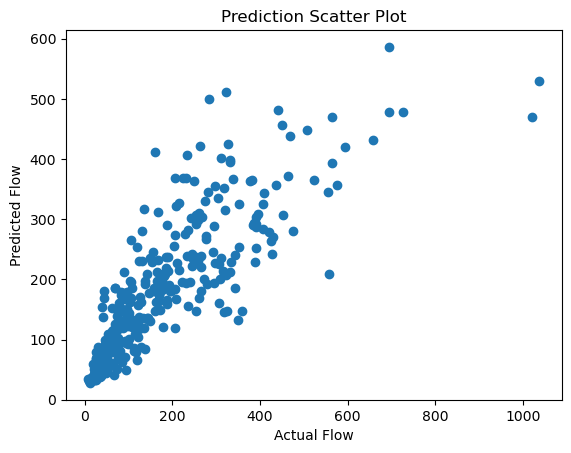

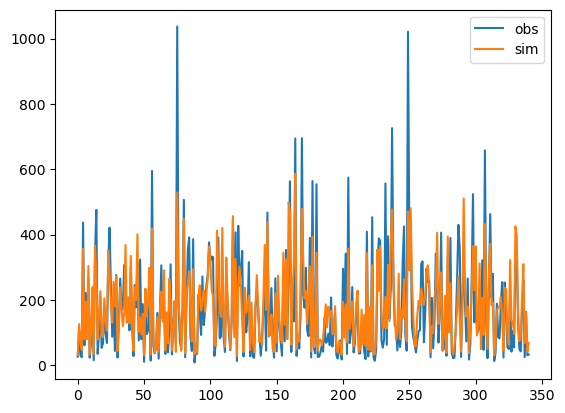

In [15]:
# Model Training - RANDOM FOREST REGRESSOR
# Define predictors and target variable
X = merged_data.drop(columns=['year', 'month', 'flow'])
y = merged_data['flow']

# Set seed for reproducibility
np.random.seed(1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

# Train Random Forest Regressor
# Tune RF's hyperparameters
rf = RandomForestRegressor(random_state = 1)
rf.get_params()

# Define grid of hyperparameters to search
params_rf = {'n_estimators' : [100, 200, 300],
             'max_depth' : [10, 15, 20],
             'min_samples_split' : [1, 2, 4],
             'min_samples_leaf' : [1, 2, 4], 
             'max_features' : ['sqrt', 'log2']}

# Perform grid search with cross-validation
grid_rf = GridSearchCV(estimator = rf, param_grid = params_rf, 
                       cv = 5, n_jobs = -1, verbose = 2)
grid_rf.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_rf.best_params_)

# Train final model with best hyperparameters
best_rf = grid_rf.best_estimator_

# Evaluate model on test set
y_pred = best_rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
r2 = r2_score(y_test, y_pred)

# Adjusted R^2
n = len(y_test)              # number of observations
p = X_test.shape[1]      # number of predictors

adj_r2_rf = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Visualize predictions vs observed flow
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Flow")
plt.ylabel("Predicted Flow")
plt.title("Prediction Scatter Plot")
plt.show()

plt.plot(y_test.values,label='obs')
plt.plot(y_pred,label='sim')
plt.legend()
plt.show()

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.5s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=

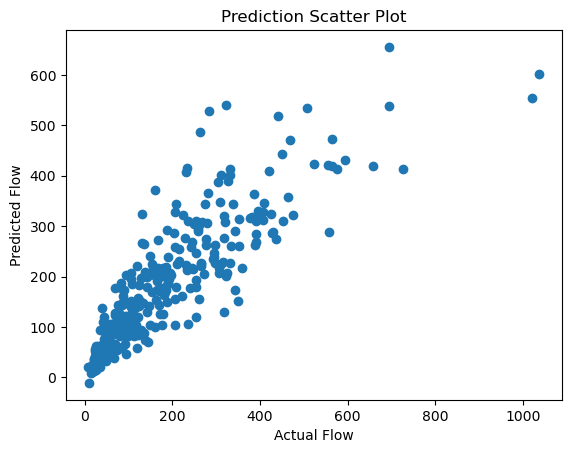

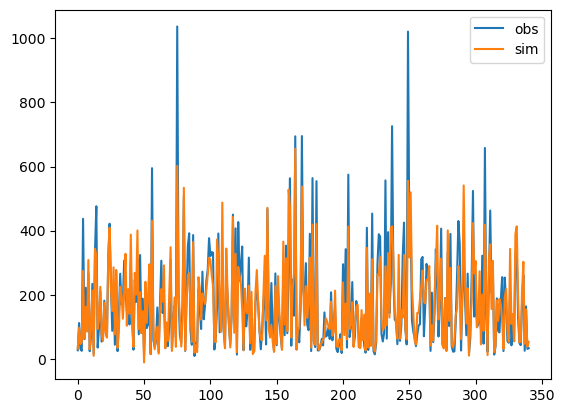

In [16]:
# Train Gradient Boosting Regressor
# First create imputer that fills missing values with mean of column
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

# Train GB model
gb = GradientBoostingRegressor(random_state = 1)
gb.get_params()

# Define grid of hyperparameters to search
params_gb = {'n_estimators' : [100, 150, 200, 250, 300],
             'learning_rate' : [0.01, 0.05, 0.075, 1],
             'max_depth' : [5, 7, 9],
             'min_samples_split' : [2, 4],
             'min_samples_leaf' : [1, 2]}

# Perform grid search with cross-validation
grid_gb = GridSearchCV(estimator = gb, param_grid = params_gb, 
                       cv = 5, n_jobs = -1, verbose = 2)
grid_gb.fit(X_train_imp, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_gb.best_params_)

# Train final model with best hyperparameters
best_gb = grid_gb.best_estimator_

# Evaluate model on test set
y_pred_gb = best_gb.predict(X_test_imp)
rmse_gb = mean_squared_error(y_test, y_pred_gb)**(1/2)
r2_gb = r2_score(y_test, y_pred_gb)

# Adjusted R^2
n = len(y_test)              # number of observations
p = X_test_imp.shape[1]      # number of predictors

adj_r2_gb = 1 - (1 - r2_gb) * (n - 1) / (n - p - 1)

#Visualize predictions vs observed flow
plt.scatter(y_test,y_pred_gb)
plt.xlabel("Actual Flow")
plt.ylabel("Predicted Flow")
plt.title("Prediction Scatter Plot")
plt.show()

plt.plot(y_test.values,label='obs')
plt.plot(y_pred_gb,label='sim')
plt.legend()
plt.show()

In [17]:
# Assessment
print(merged_data['flow'].mean())
print("Root Mean Squared Error (RF):", rmse)
print("R^2 Score (RF):", r2)
print("Adjusted R^2 Score (RF):", adj_r2_rf)
print("Root Mean Squared Error (GB):", rmse_gb)
print("R^2 Score (GB):", r2_gb)
print("Adjusted R^2 Score (GB):", adj_r2_gb)

188.0946167400881
Root Mean Squared Error (RF): 88.43334416498762
R^2 Score (RF): 0.6858541433174157
Adjusted R^2 Score (RF): 0.6713551037782195
Root Mean Squared Error (GB): 78.27822497509611
R^2 Score (GB): 0.7538605774435718
Adjusted R^2 Score (GB): 0.7425002964025058


/var/folders/07/x3tw6f7d02b9sg78zrz3df7r0000gn/T/ipykernel_67861/2101949186.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_rf, X_train, plot_type="bar")


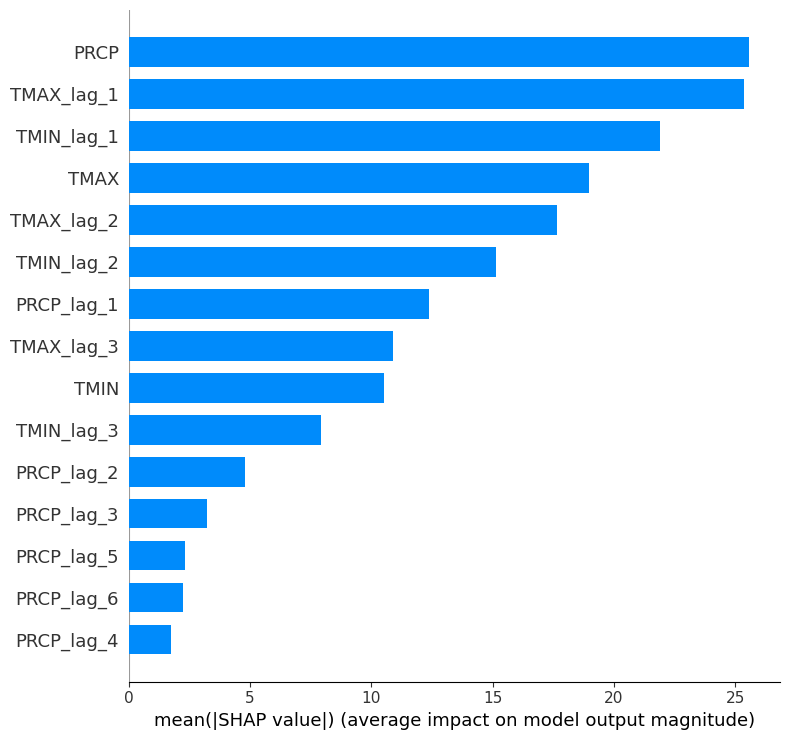

/var/folders/07/x3tw6f7d02b9sg78zrz3df7r0000gn/T/ipykernel_67861/2101949186.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_gb, X_train_imp_df, plot_type="bar")


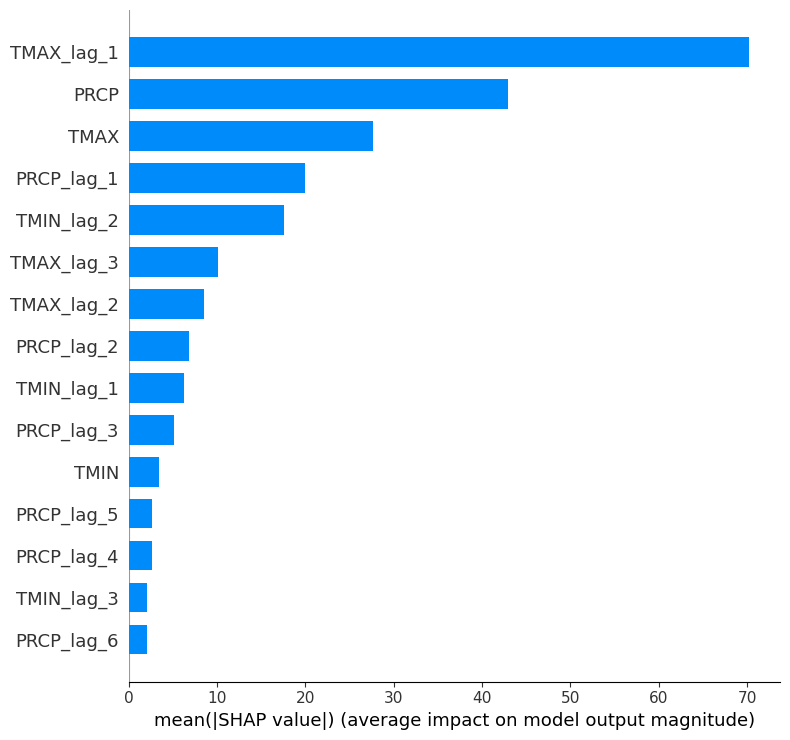

In [18]:
# SHAP - Avergage Feature Importance
#RF
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_train)
shap.summary_plot(shap_values_rf, X_train, plot_type="bar")

#GB
X_train_imp_df = pd.DataFrame(X_train_imp, columns=X.columns)
explainer_gb = shap.TreeExplainer(best_gb)
shap_values_gb = explainer_gb.shap_values(X_train_imp_df)
shap.summary_plot(shap_values_gb, X_train_imp_df, plot_type="bar")


In [19]:
# Data Collection & Cleaning from NASA NEX-GDDP-CMIP6 
# https://nex-gddp-cmip6.s3.us-west-2.amazonaws.com/index.html#NEX-GDDP-CMIP6/GFDL-ESM4/ssp245/r1i1p1f1/
# ssp585 - high emissions scenario

# Ithaca, NY coordinates : 42.4440° N, 76.5019° W
lat = 42.4440
lon = 283.4981

# Precipitation
files = sorted(glob.glob("pr_day_GFDL-ESM4_ssp585_r1i1p1f1_gr1_*.nc")) # in kg m-2 s-1 !!
badfuture_pr = []

for f in files:
    ds = xr.open_dataset(f)
    pr = ds['pr'].sel(lat=lat, lon=lon, method='nearest')

    # Convert to mm/day (1 kg/m2 = 1mm water depth)
    pr_mm_day = pr * 86400
    
    # Convert daily → monthly mean
    pr_month = pr_mm_day.resample(time='1M').mean().to_pandas()
    pr_month.index = pr_month.index.to_datetimeindex() 
    badfuture_pr.append(pr_month)

badfuture_pr = pd.concat(badfuture_pr)
badfuture_pr = badfuture_pr.rename("PRCP")

# Temperature in Kelvin !
files2 = sorted(glob.glob("tasmax_day_GFDL-ESM4_ssp585_r1i1p1f1_gr1_*.nc")) # in K !!
badfuture_TMAX = []

for f in files2:
    ds = xr.open_dataset(f)
    TMAX = ds['tasmax'].sel(lat=lat, lon=lon, method='nearest')
    
    # Convert Kelvin to Fahrenheit 
    TMAX = (TMAX - 273.15) * 9/5 + 32

    # Convert daily → monthly mean
    TMAX_month = TMAX.resample(time='1M').mean().to_pandas()
    TMAX_month.index = TMAX_month.index.to_datetimeindex()
    badfuture_TMAX.append(TMAX_month)

badfuture_TMAX = pd.concat(badfuture_TMAX)
badfuture_TMAX = badfuture_TMAX.rename("TMAX")

files3 = sorted(glob.glob("tasmin_day_GFDL-ESM4_ssp585_r1i1p1f1_gr1_*.nc")) # in K !!
badfuture_TMIN = []

for f in files3:
    ds = xr.open_dataset(f)
    TMIN = ds['tasmin'].sel(lat=lat, lon=lon, method='nearest')
    
    # Convert Kelvin to Fahrenheit 
    TMIN = (TMIN - 273.15) * 9/5 + 32

    # Convert daily → monthly mean
    TMIN_month = TMIN.resample(time='1M').mean().to_pandas()
    TMIN_month.index = TMIN_month.index.to_datetimeindex()
    badfuture_TMIN.append(TMIN_month)

badfuture_TMIN = pd.concat(badfuture_TMIN)
badfuture_TMIN = badfuture_TMIN.rename("TMIN")

# Combine PRCP + TMIN + TMAX
badfuture_climate = pd.concat([badfuture_pr, badfuture_TMIN, badfuture_TMAX], axis=1)

# Sort chronologically
badfuture_climate = badfuture_climate.sort_index()

# Add year and month columns
badfuture_climate['year'] = badfuture_climate.index.year
badfuture_climate['month'] = badfuture_climate.index.month

# Reset index for clarity
badfuture_climate = badfuture_climate.reset_index().rename(columns={'index':'DATE'})

# Match historical ordering
badfuture_climate = badfuture_climate[['year', 'month', 'PRCP', 'TMIN', 'TMAX']]

<string>:7: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' instead of 'M'.
/var/folders/07/x3tw6f7d02b9sg78zrz3df7r0000gn/T/ipykernel_67861/1507711838.py:22: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  pr_month.index = pr_month.index.to_datetimeindex()
/var/folders/07/x3tw6f7d02b9sg78zrz3df7r0000gn/T/ipykernel_67861/1507711838.py:22: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  pr_month.index = pr_month.index.to_datetimeindex()
<string>:7: FutureWarning: 'M' is deprecated and will be removed in a future version. Please use 'ME' 

In [20]:
# ============================================================
# 1. PREPARE FUTURE DATAFRAME (start at June 2025)
# ============================================================

# Your raw future climate data (monthly GCM output)
future = badfuture_climate.copy()

# Keep ONLY months strictly after the last historical month (2025-05)
future = future[(future['year'] > 2025) | ((future['year'] == 2025) & (future['month'] >= 6))]

future = future.reset_index(drop=True)
future['year'] = future['year'].astype(int)
future['month'] = future['month'].astype(int)


# ============================================================
# 2. GET LAST 3 HISTORICAL CLIMATE MONTHS (for lags)
# ============================================================

hist = merged_data.copy()

last_hist_prcp_1 = hist.iloc[-1]['PRCP']      # May 2025
last_hist_prcp_2 = hist.iloc[-2]['PRCP']      # Apr 2025
last_hist_prcp_3 = hist.iloc[-3]['PRCP']      # Mar 2025
last_hist_prcp_4 = hist.iloc[-4]['PRCP']      # Feb 2025
last_hist_prcp_5 = hist.iloc[-5]['PRCP']      # Jan 2025
last_hist_prcp_6 = hist.iloc[-6]['PRCP']      # Dec 2024

last_hist_tmin_1 = hist.iloc[-1]['TMIN']
last_hist_tmin_2 = hist.iloc[-2]['TMIN']
last_hist_tmin_3 = hist.iloc[-3]['TMIN']
last_hist_tmin_4 = hist.iloc[-4]['TMIN']

last_hist_tmax_1 = hist.iloc[-1]['TMAX']
last_hist_tmax_2 = hist.iloc[-2]['TMAX']
last_hist_tmax_3 = hist.iloc[-3]['TMAX']
last_hist_tmax_4 = hist.iloc[-4]['TMAX']

# ============================================================
# 3. CREATE 1–4 MONTH CLIMATE LAGS
# ============================================================

future['PRCP_lag_1'] = None
future['PRCP_lag_2'] = None
future['PRCP_lag_3'] = None
future['PRCP_lag_4'] = None
future['PRCP_lag_5'] = None
future['PRCP_lag_6'] = None

future['TMIN_lag_1'] = None
future['TMIN_lag_2'] = None
future['TMIN_lag_3'] = None
future['TMIN_lag_4'] = None

future['TMAX_lag_1'] = None
future['TMAX_lag_2'] = None
future['TMAX_lag_3'] = None
future['TMAX_lag_4'] = None

for i in range(len(future)):

    if i == 0:
        # FIRST FUTURE MONTH = JUNE 2025
        # Use last 3 historical observed months
        future.loc[i, 'PRCP_lag_1'] = last_hist_prcp_1
        future.loc[i, 'PRCP_lag_2'] = last_hist_prcp_2
        future.loc[i, 'PRCP_lag_3'] = last_hist_prcp_3
        future.loc[i, 'PRCP_lag_4'] = last_hist_prcp_4
        future.loc[i, 'PRCP_lag_5'] = last_hist_prcp_5
        future.loc[i, 'PRCP_lag_6'] = last_hist_prcp_6

        future.loc[i, 'TMIN_lag_1'] = last_hist_tmin_1
        future.loc[i, 'TMIN_lag_2'] = last_hist_tmin_2
        future.loc[i, 'TMIN_lag_3'] = last_hist_tmin_3
        #future.loc[i, 'TMIN_lag_4'] = last_hist_tmin_4

        future.loc[i, 'TMAX_lag_1'] = last_hist_tmax_1
        future.loc[i, 'TMAX_lag_2'] = last_hist_tmax_2
        future.loc[i, 'TMAX_lag_3'] = last_hist_tmax_3
        #future.loc[i, 'TMAX_lag_4'] = last_hist_tmax_4

    elif i == 1:
        # SECOND FUTURE MONTH
        future.loc[i, 'PRCP_lag_1'] = future.loc[i-1, 'PRCP']
        future.loc[i, 'PRCP_lag_2'] = last_hist_prcp_1
        future.loc[i, 'PRCP_lag_3'] = last_hist_prcp_2
        future.loc[i, 'PRCP_lag_4'] = last_hist_prcp_3
        future.loc[i, 'PRCP_lag_5'] = last_hist_prcp_4
        future.loc[i, 'PRCP_lag_6'] = last_hist_prcp_5

        future.loc[i, 'TMIN_lag_1'] = future.loc[i-1, 'TMIN']
        future.loc[i, 'TMIN_lag_2'] = last_hist_tmin_1
        future.loc[i, 'TMIN_lag_3'] = last_hist_tmin_2
        #future.loc[i, 'TMIN_lag_4'] = last_hist_tmin_3

        future.loc[i, 'TMAX_lag_1'] = future.loc[i-1, 'TMAX']
        future.loc[i, 'TMAX_lag_2'] = last_hist_tmax_1
        future.loc[i, 'TMAX_lag_3'] = last_hist_tmax_2
        #future.loc[i, 'TMAX_lag_4'] = last_hist_tmax_3

    elif i == 2:
        # THIRD FUTURE MONTH
        future.loc[i, 'PRCP_lag_1'] = future.loc[i-1, 'PRCP']
        future.loc[i, 'PRCP_lag_2'] = future.loc[i-2, 'PRCP']
        future.loc[i, 'PRCP_lag_3'] = last_hist_prcp_1
        future.loc[i, 'PRCP_lag_4'] = last_hist_prcp_2
        future.loc[i, 'PRCP_lag_5'] = last_hist_prcp_3
        future.loc[i, 'PRCP_lag_6'] = last_hist_prcp_4

        future.loc[i, 'TMIN_lag_1'] = future.loc[i-1, 'TMIN']
        future.loc[i, 'TMIN_lag_2'] = future.loc[i-2, 'TMIN']
        future.loc[i, 'TMIN_lag_3'] = last_hist_tmin_1
        #future.loc[i, 'TMIN_lag_4'] = last_hist_tmin_2

        future.loc[i, 'TMAX_lag_1'] = future.loc[i-1, 'TMAX']
        future.loc[i, 'TMAX_lag_2'] = future.loc[i-2, 'TMAX']
        future.loc[i, 'TMAX_lag_3'] = last_hist_tmax_1
        #future.loc[i, 'TMAX_lag_4'] = last_hist_tmax_2

    elif i == 3:
        future.loc[i, 'PRCP_lag_1'] = future.loc[i-1, 'PRCP']
        future.loc[i, 'PRCP_lag_2'] = future.loc[i-2, 'PRCP']
        future.loc[i, 'PRCP_lag_3'] = future.loc[i-3, 'PRCP']
        future.loc[i, 'PRCP_lag_4'] = last_hist_prcp_1
        future.loc[i, 'PRCP_lag_5'] = last_hist_prcp_2
        future.loc[i, 'PRCP_lag_6'] = last_hist_prcp_3

        future.loc[i, 'TMIN_lag_1'] = future.loc[i-1, 'TMIN']
        future.loc[i, 'TMIN_lag_2'] = future.loc[i-2, 'TMIN']
        future.loc[i, 'TMIN_lag_3'] = future.loc[i-3, 'TMIN']
        #future.loc[i, 'TMIN_lag_4'] = last_hist_tmin_1

        future.loc[i, 'TMAX_lag_1'] = future.loc[i-1, 'TMAX']
        future.loc[i, 'TMAX_lag_2'] = future.loc[i-2, 'TMAX']
        future.loc[i, 'TMAX_lag_3'] = future.loc[i-3, 'TMAX']
        #future.loc[i, 'TMAX_lag_4'] = last_hist_tmax_1

    elif i == 4:
        future.loc[i, 'PRCP_lag_1'] = future.loc[i-1, 'PRCP']
        future.loc[i, 'PRCP_lag_2'] = future.loc[i-2, 'PRCP']
        future.loc[i, 'PRCP_lag_3'] = future.loc[i-3, 'PRCP']
        future.loc[i, 'PRCP_lag_4'] = future.loc[i-4, 'PRCP']
        future.loc[i, 'PRCP_lag_5'] = last_hist_prcp_1
        future.loc[i, 'PRCP_lag_6'] = last_hist_prcp_2

        future.loc[i, 'TMIN_lag_1'] = future.loc[i-1, 'TMIN']
        future.loc[i, 'TMIN_lag_2'] = future.loc[i-2, 'TMIN']
        future.loc[i, 'TMIN_lag_3'] = future.loc[i-3, 'TMIN']
        #future.loc[i, 'TMIN_lag_4'] = future.loc[i-4, 'TMIN']

        future.loc[i, 'TMAX_lag_1'] = future.loc[i-1, 'TMAX']
        future.loc[i, 'TMAX_lag_2'] = future.loc[i-2, 'TMAX']
        future.loc[i, 'TMAX_lag_3'] = future.loc[i-3, 'TMAX']
        #future.loc[i, 'TMAX_lag_4'] = future.loc[i-4, 'TMAX']

    elif i == 5:
        future.loc[i, 'PRCP_lag_1'] = future.loc[i-1, 'PRCP']
        future.loc[i, 'PRCP_lag_2'] = future.loc[i-2, 'PRCP']
        future.loc[i, 'PRCP_lag_3'] = future.loc[i-3, 'PRCP']
        future.loc[i, 'PRCP_lag_4'] = future.loc[i-4, 'PRCP']
        future.loc[i, 'PRCP_lag_5'] = future.loc[i-5, 'PRCP']
        future.loc[i, 'PRCP_lag_6'] = last_hist_prcp_1

        future.loc[i, 'TMIN_lag_1'] = future.loc[i-1, 'TMIN']
        future.loc[i, 'TMIN_lag_2'] = future.loc[i-2, 'TMIN']
        future.loc[i, 'TMIN_lag_3'] = future.loc[i-3, 'TMIN']
        #future.loc[i, 'TMIN_lag_4'] = future.loc[i-4, 'TMIN']

        future.loc[i, 'TMAX_lag_1'] = future.loc[i-1, 'TMAX']
        future.loc[i, 'TMAX_lag_2'] = future.loc[i-2, 'TMAX']
        future.loc[i, 'TMAX_lag_3'] = future.loc[i-3, 'TMAX']
        #future.loc[i, 'TMAX_lag_4'] = future.loc[i-4, 'TMAX']

    else:
        future.loc[i, 'PRCP_lag_1'] = future.loc[i-1, 'PRCP']
        future.loc[i, 'PRCP_lag_2'] = future.loc[i-2, 'PRCP']
        future.loc[i, 'PRCP_lag_3'] = future.loc[i-3, 'PRCP']
        future.loc[i, 'PRCP_lag_4'] = future.loc[i-4, 'PRCP']
        future.loc[i, 'PRCP_lag_5'] = future.loc[i-5, 'PRCP']
        future.loc[i, 'PRCP_lag_6'] = future.loc[i-6, 'PRCP']

        future.loc[i, 'TMIN_lag_1'] = future.loc[i-1, 'TMIN']
        future.loc[i, 'TMIN_lag_2'] = future.loc[i-2, 'TMIN']
        future.loc[i, 'TMIN_lag_3'] = future.loc[i-3, 'TMIN']
        #future.loc[i, 'TMIN_lag_4'] = future.loc[i-4, 'TMIN']

        future.loc[i, 'TMAX_lag_1'] = future.loc[i-1, 'TMAX']
        future.loc[i, 'TMAX_lag_2'] = future.loc[i-2, 'TMAX']
        future.loc[i, 'TMAX_lag_3'] = future.loc[i-3, 'TMAX']
        #future.loc[i, 'TMAX_lag_4'] = future.loc[i-4, 'TMAX']

# ============================================================
# 4. RUN PREDICTIONS
# ============================================================

FEATURE_ORDER = [
    'PRCP', 'TMAX', 'TMIN',
    'PRCP_lag_1', 'TMIN_lag_1', 'TMAX_lag_1',
    'PRCP_lag_2', 'TMIN_lag_2', 'TMAX_lag_2',
    'PRCP_lag_3', 'TMIN_lag_3', 'TMAX_lag_3',
    'PRCP_lag_4', 'PRCP_lag_5', 'PRCP_lag_6'
]

predicted = []

for i in range(len(future)):

    X_row = future.loc[i, FEATURE_ORDER].values.reshape(1, -1)

    # Apply imputer (must match training)
    X_row_imp = imputer.transform(X_row)

    # Predict
    y_pred = best_gb.predict(X_row_imp)[0]
    predicted.append(y_pred)

future['predicted_flow'] = predicted

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-

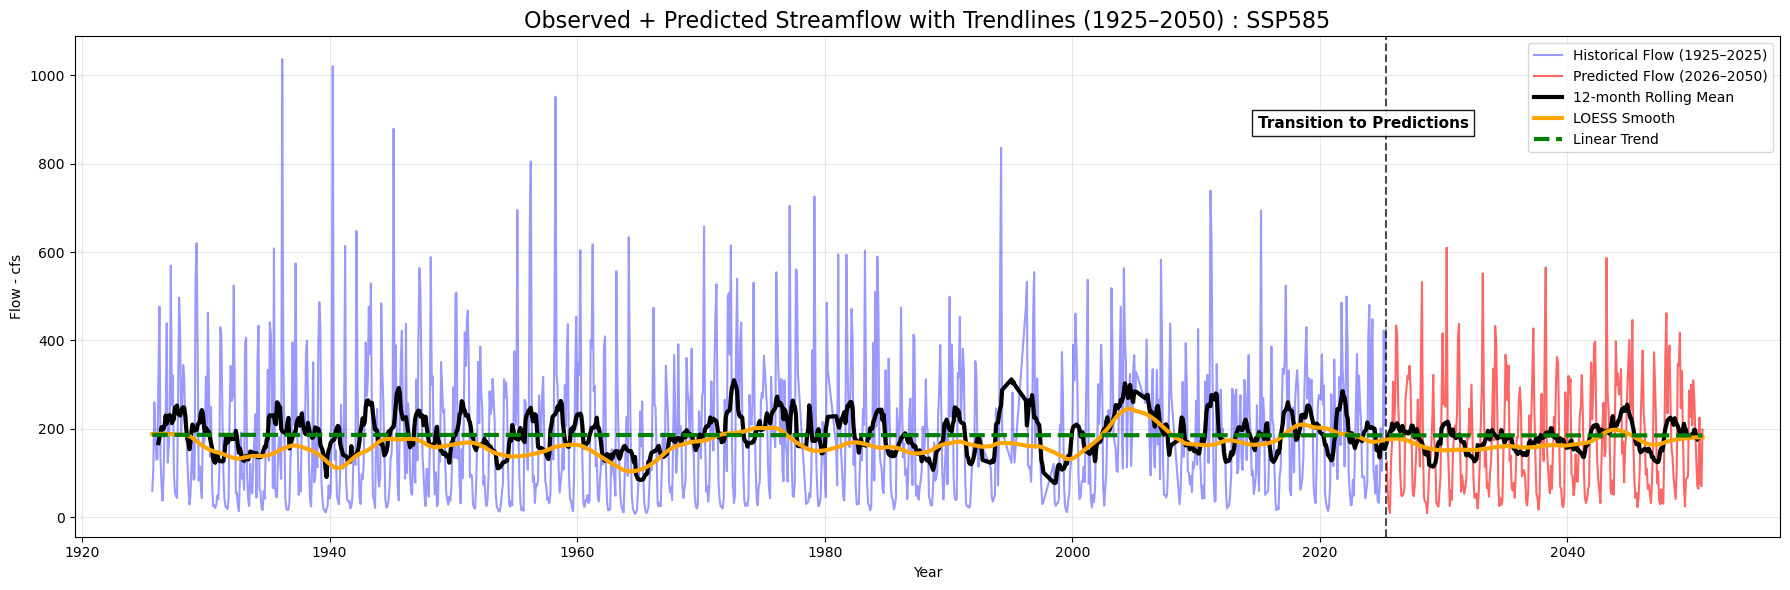

In [28]:
badfuture_plot = future.copy()
badfuture_plot['DATE'] = pd.to_datetime(badfuture_plot[['year','month']].assign(day=1))

badfuture_plot = badfuture_plot[['DATE', 'predicted_flow']]
badfuture_plot = badfuture_plot.rename(columns={'predicted_flow': 'flow'})

hist = merged_data.copy()
hist['DATE'] = pd.to_datetime(hist[['year','month']].assign(day=1))
hist = hist[['DATE','flow']]

badcombined = pd.concat([hist, badfuture_plot], ignore_index=True)
badcombined = badcombined.sort_values('DATE')

# ------------------------------------------------
# 1. Compute 12-month rolling mean
# ------------------------------------------------
badcombined['rolling_12m'] = badcombined['flow'].rolling(window=12, center=True).mean()

# ------------------------------------------------
# 2. LOESS smoothed curve
# ------------------------------------------------
loess_smoothed = lowess(badcombined['flow'], badcombined['DATE'], frac=0.05)  # smaller frac = less smoothing
badcombined['loess'] = loess_smoothed[:, 1]

# ------------------------------------------------
# 3. Linear regression trendline
# ------------------------------------------------
badcombined['t'] = np.arange(len(badcombined))
x1, x2 = np.polyfit(badcombined['t'], badcombined['flow'], 1)
badcombined['linear_trend'] = x1 * badcombined['t'] + x2

# ------------------------------------------------
# Create Plot
# ------------------------------------------------
plt.figure(figsize=(18, 6))

# Historical
plt.plot(hist['DATE'], hist['flow'], color='blue', alpha=0.4, label='Historical Flow (1925–2025)')

# Predicted
plt.plot(badfuture_plot['DATE'], badfuture_plot['flow'], color='red', alpha=0.6, label='Predicted Flow (2026–2050)')

# Rolling 12-month mean
plt.plot(badcombined['DATE'], badcombined['rolling_12m'], 
         color='black', linewidth=3, label='12-month Rolling Mean')

# LOESS smooth curve
plt.plot(badcombined['DATE'], badcombined['loess'], 
         color='orange', linewidth=3, label='LOESS Smooth')

# Linear regression trend
plt.plot(badcombined['DATE'], badcombined['linear_trend'], 
         color='green', linewidth=3, linestyle='--', label='Linear Trend')

# Transition marker
plt.axvline(pd.Timestamp('2025-05-01'), color='black', linestyle='--', alpha=0.7)
plt.annotate(
    'Transition to Predictions',
    xy=(pd.Timestamp('2025-05-01'), badcombined['flow'].mean()),
    xytext=(pd.Timestamp('2015-01-01'), badcombined['flow'].max() * 0.85),
    fontsize=11,
    fontweight='bold',
    bbox=dict(facecolor='white', edgecolor='black', alpha=0.9)
)

# Labels, legend, grid
plt.title("Observed + Predicted Streamflow with Trendlines (1925–2050) : SSP585", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Flow - cfs")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

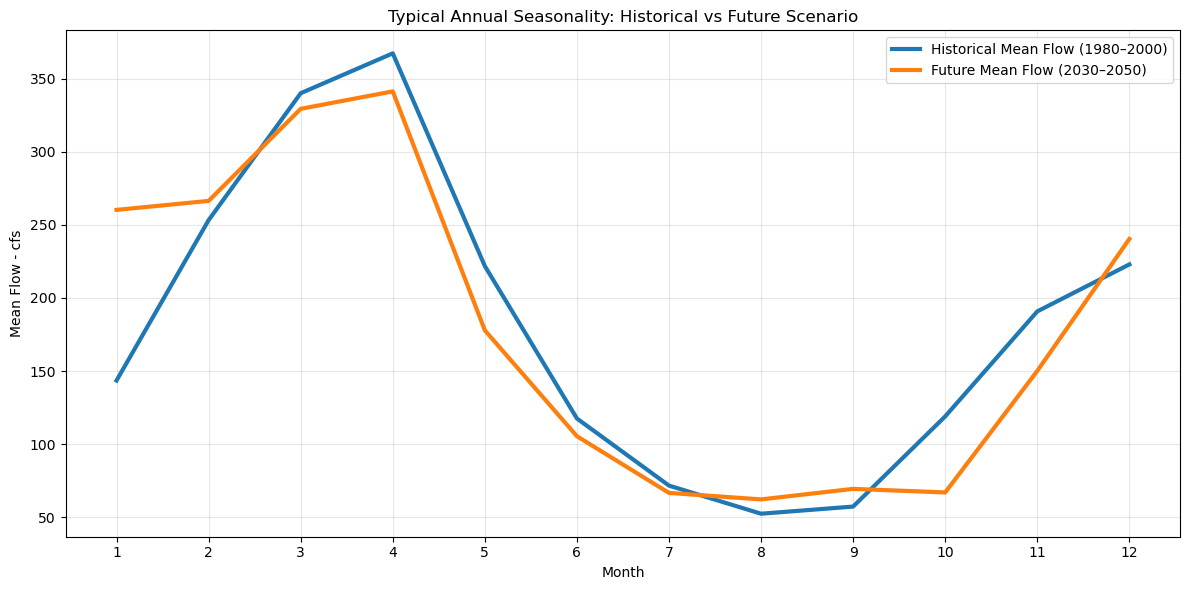

In [22]:
# Typical Yearly Flow Seasonality in Past VS Future
#1. PREPARE HISTORICAL SEASONALITY (1980–2000)
hist = merged_data.copy()
hist['DATE'] = pd.to_datetime(hist[['year','month']].assign(day=1))

hist_period = hist[(hist['year'] >= 1980) & (hist['year'] <= 2000)]

#Mean monthly flow across all years
hist_seasonal = hist_period.groupby('month')['flow'].mean()

#2. PREPARE FUTURE SEASONALITY (2030–2050)
future_df = future.copy()
future_df['DATE'] = pd.to_datetime(future_df[['year','month']].assign(day=1))

future_period = future_df[(future_df['year'] >= 2030) & (future_df['year'] <= 2050)]

#Mean monthly predicted flow across future years
future_seasonal = future_period.groupby('month')['predicted_flow'].mean()

#3. PLOT SEASONALITY COMPARISON
plt.figure(figsize=(12,6))

plt.plot(hist_seasonal.index, hist_seasonal.values,
label='Historical Mean Flow (1980–2000)', linewidth=3)

plt.plot(future_seasonal.index, future_seasonal.values,
label='Future Mean Flow (2030–2050)', linewidth=3)

plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel("Mean Flow - cfs")
plt.title("Typical Annual Seasonality: Historical vs Future Scenario")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Model Tuning - BiasVariance Tradeoff Analysis

def bias_variance_decomposition(model, X, y, n_boot=200):
    """
    Computes bias^2 and variance using bootstrap resampling on real dataset.
    """
    preds = []

    for _ in range(n_boot):
        # bootstrap sample
        X_s, y_s = resample(X, y)
        model_clone = GradientBoostingRegressor(**model.get_params())
        model_clone.fit(X_s, y_s)

        preds.append(model_clone.predict(X))

    preds = np.array(preds)
    avg_pred = np.mean(preds, axis=0)

    # Bias^2 and variance
    bias2 = np.mean((avg_pred - y) ** 2)
    variance = np.mean(np.var(preds, axis=0))

    return bias2, variance

# Run diagnostics on TRAINING data (common practice)
bias2, var = bias_variance_decomposition(best_gb, X_train_imp, y_train)

print("Bias²:", bias2)
print("Variance:", var)
print("Bias² + Variance:", bias2 + var)

estimators = [50, 100, 150, 200, 300]
bias_list = []
var_list = []

for n in estimators:
    params = best_gb.get_params().copy()
    params["n_estimators"] = n   # overwrite existing value

    model = GradientBoostingRegressor(**params)

    b2, v = bias_variance_decomposition(model, X_train_imp, y_train, n_boot=150)
    bias_list.append(b2)
    var_list.append(v)

plt.plot(estimators, bias_list, label="Bias²")
plt.plot(estimators, var_list, label="Variance")
plt.xlabel("n_estimators")
plt.ylabel("Value")
plt.legend()
plt.title("Bias–Variance Curve for Gradient Boosting")
plt.show()

Bias²: 1096.3503637408382
Variance: 1408.2259073892476
Bias² + Variance: 2504.576271130086


Exception ignored in: <function ResourceTracker.__del__ at 0x10462e0c0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104d9e0c0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102baa0c0>
Traceback (most recent call last

KeyboardInterrupt: 